In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.gaia_configs import Gaia_MLP_FlowMatch as Configs

configs = Configs(data_name = 'h277',
                features = ['x', 'y', 'z', 'vx', 'vy', 'vz'],
                 data_split_fracs = [0.8, 0.2, 0.0],
                 preprocess=['unit_ball_transform', 'radial_blowup', 'standardize'],
                 batch_size = 2048,
                 epochs = 100,
                 lr = 1e-3,
                 dim_hidden = 64, 
                 sigma = 0.1,
                 solver='dopri5',
                 num_sampling_steps=100  
                )
#...set working directory for results:

configs.set_workdir(path='../results', save_config=True)

#================================================================
INFO: created directory: ../results/MLP.h277_2023.10.04_20h20__1
#================================================================
+--------------------+--------------------------------------------------------------------------------------------------+
| Parameters         | Values                                                                                           |
+--------------------+--------------------------------------------------------------------------------------------------+
| data_name          | h277                                                                                             |
| dataset            | ['../data/gaia/data.angle_340.smeared_00.npy', '../data/gaia/data.angle_340.smeared_00.cov.npy'] |
| features           | ['x', 'y', 'z', 'vx', 'vy', 'vz']                                                                |
| dim_input          | 6                                               

In [2]:
from DynGenModels.datamodules.gaia.datasets import GaiaDataset 
from DynGenModels.datamodules.gaia.dataloader import GaiaDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.flowmatch import SimplifiedCondFlowMatching

dataset = GaiaDataset(configs)
dataloader = GaiaDataLoader(dataset, configs)
net = MLP(configs)
dynamics = SimplifiedCondFlowMatching(net, configs)
cfm = DynGenModelTrainer(dynamics, dataloader, configs)
cfm.train()

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 128667, validation size: 32166, testing sizes: 1
INFO: number of training parameters: 9222


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

### generate data from trained model:

In [9]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.gaia.dataprocess import PostProcessGaiaData 
pipeline = FlowMatchPipeline(trained_model=cfm, 
                             source_input=torch.randn(50000, 6),
                             configs=configs, 
                             postprocessor=PostProcessGaiaData)

INFO: neural ODE solver with dopri5 method and steps=100
INFO: post-processing sampled data with ['inverse_standardize', 'inverse_radial_blowup', 'inverse_unit_ball_transform']


###  Performance plots

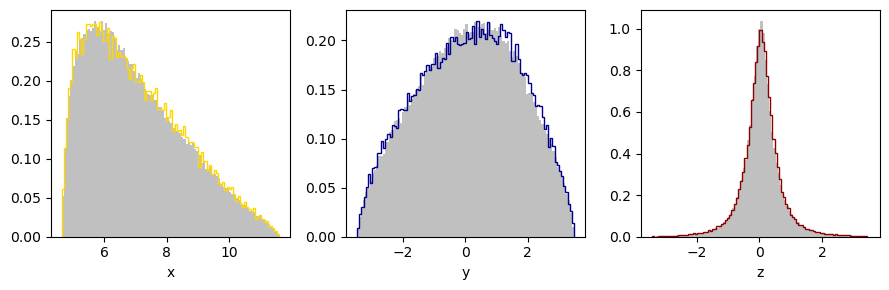

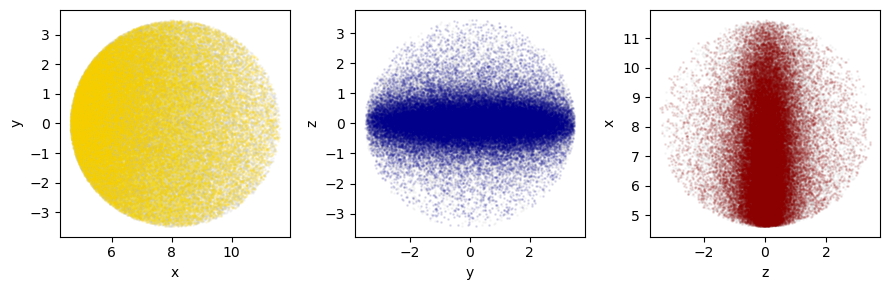

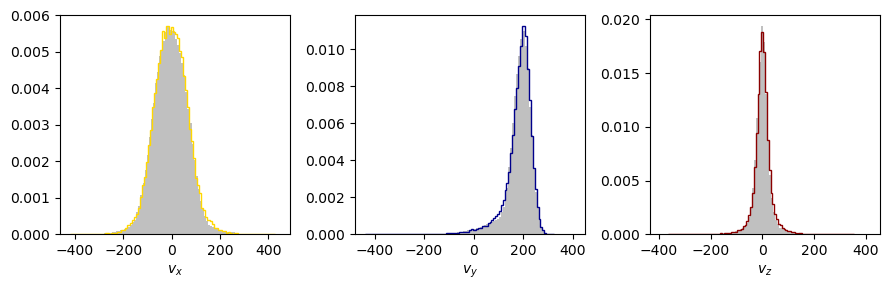

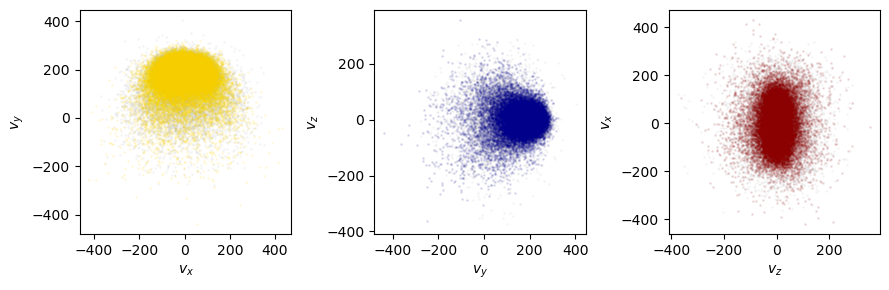

In [16]:
coord = ['x', 'y', 'z']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(dataset.target[..., i], bins=100, color='silver', density=True)
    ax[i].hist(pipeline.target[..., i], bins=100, color=color[i], histtype='step', density=True)
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(dataset.target[:50000, i], dataset.target[:50000, j], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i], pipeline.target[:50000, j], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()

coord = [r'$v_x$', r'$v_y$', r'$v_z$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(dataset.target[..., i+3], bins=100, color='silver', density=True)
    ax[i].hist(pipeline.target[..., i+3], bins=100, color=color[i], histtype='step', density=True)
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(dataset.target[:50000, i+3], dataset.target[:50000, j+3], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i+3], pipeline.target[:50000, j+3], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])

plt.tight_layout()
plt.show()